In [1]:
import io
import re
import pandas as pd
import matplotlib.pyplot as plt
import chess
import chess.pgn
import sklearn
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.decomposition import PCA
from sklearn.datasets import make_classification
from sklearn.metrics import roc_curve, auc, roc_auc_score, confusion_matrix, recall_score, precision_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import r2_score
import seaborn as sns
import statsmodels.api as sm




# get data

In [2]:
ogdf = pd.read_csv('club_games_data.csv')

In [3]:
df = ogdf.copy()

In [4]:
len(df)

66879

# Making data

In [5]:
def count_pawn_moves(pgn_str):
    pgn = chess.pgn.read_game(io.StringIO(pgn_str))
    board = pgn.board()
    pawn_moves = {'White': [0]*8, 'Black': [0]*8}
    for move in pgn.mainline_moves():
        rank = chess.square_rank(move.from_square)
        moved_piece = board.piece_at(move.from_square)
        if not moved_piece:
            return{'White': [0]*8, 'Black': [0]*8} 
        if moved_piece.piece_type == chess.PAWN:
            if moved_piece.color == chess.WHITE:
                pawn_moves['White'][rank] += 1
            else:
                pawn_moves['Black'][rank] += 1
        board.push(move)
    return pawn_moves

print(count_pawn_moves(ogdf['pgn'].iloc[0]))

{'White': [0, 5, 0, 2, 0, 0, 0, 0], 'Black': [0, 0, 0, 0, 0, 3, 4, 0]}


In [6]:
df[['black_pawn_moves', 'white_pawn_moves']] = ogdf.apply(lambda row: pd.Series(count_pawn_moves(row['pgn'])), axis=1)

In [7]:
df['white_win'] = df.apply(lambda row: 1 if row['white_result'] == 'win' else 0, axis=1)
df['black_win'] = df.apply(lambda row: 1 if row['black_result'] == 'win' else 0, axis=1)


In [8]:
df['white_simple_result']=df.apply(lambda row: 'win' if row['white_result'] == 'win' else 'loss' if row['black_result']=='win' else 'draw', axis=1)
df['black_simple_result']=df.apply(lambda row: 'win' if row['black_result'] == 'win' else 'loss' if row['white_result']=='win' else 'draw', axis=1)

In [9]:
df['white_simple_result_ft']=df.apply(lambda row: 2 if row['white_result'] == 'win' else 0 if row['black_result']=='win' else 1, axis=1)
df['black_simple_result_ft']=df.apply(lambda row: 2 if row['black_result'] == 'win' else 0 if row['white_result']=='win' else 1, axis=1)

In [10]:
df['Elo_class'] = pd.cut(df['white_rating'], bins=[0, 500, 1000, 1200, 1400, 1600, 1800, 2000, 2200, 2300, 2400, 2500, 2700, 3100], labels=[
                         '<500', '500-1000', '1000-1200', '1200-1400', '1400-1600', '1600-1800', '1800-2000', '2000-2200', '2200-2300', '2300-2400', '2400-2500', '2500-2700', '2700-3000'])

df['sum_white_pawn_moves'] = df['white_pawn_moves'].apply(lambda x: sum(x))

df['sum_black_pawn_moves'] = df['black_pawn_moves'].apply(lambda x: sum(x))

df['sum_pawn_moves'] = df['sum_white_pawn_moves'] + df['sum_black_pawn_moves']



In [11]:
df.head()

,white_username,black_username,white_id,black_id,white_rating,black_rating,white_result,black_result,time_class,time_control,...,white_win,black_win,white_simple_result,black_simple_result,white_simple_result_ft,black_simple_result_ft,Elo_class,sum_white_pawn_moves,sum_black_pawn_moves,sum_pawn_moves
0,-Amos-,miniman2804,https://api.chess.com/pub/player/-amos-,https://api.chess.com/pub/player/miniman2804,1708,1608,win,checkmated,daily,1/259200,...,1,0,win,loss,2,0,1600-1800,7,7,14
1,-Amos-,koltcho69,https://api.chess.com/pub/player/-amos-,https://api.chess.com/pub/player/koltcho69,1726,1577,win,resigned,daily,1/172800,...,1,0,win,loss,2,0,1600-1800,10,10,20
2,-Amos-,enhmandah,https://api.chess.com/pub/player/-amos-,https://api.chess.com/pub/player/enhmandah,1727,842,win,resigned,daily,1/172800,...,1,0,win,loss,2,0,1600-1800,6,4,10
3,enhmandah,-Amos-,https://api.chess.com/pub/player/enhmandah,https://api.chess.com/pub/player/-amos-,819,1727,checkmated,win,daily,1/172800,...,0,1,loss,win,0,2,500-1000,3,4,7
4,-Amos-,Shalllow-Blue,https://api.chess.com/pub/player/-amos-,https://api.chess.com/pub/player/shalllow-blue,1729,1116,win,resigned,daily,1/172800,...,1,0,win,loss,2,0,1600-1800,7,10,17


# Cleaning Data


In [12]:
df = df[df['rules'] == 'chess']  # remove non-chess games
df = df[df["pgn"].apply(lambda pgn: chess.pgn.read_game(
    io.StringIO(pgn)).mainline_moves() != None)]  # remove games with no moves


In [13]:
df = df[df["pgn"].apply(lambda pgn: "Endgame" not in chess.pgn.read_game(
    io.StringIO(pgn)).headers["Event"])]  # remove endgame puzzles


In [14]:
for index, row in df.iterrows():  # remove abandoned games
    pgn = row["pgn"]
    game = chess.pgn.read_game(io.StringIO(pgn))
    start_time = game.headers["StartTime"]
    end_time = game.headers["EndTime"]
    if start_time == end_time:
        df.drop(index, inplace=True)


In [15]:
df = df[df['sum_pawn_moves']!=0]

In [16]:
df = df[df['black_result'] != 'abandoned']
df = df[df['white_result'] != 'abandoned']

In [17]:
df.head()

,white_username,black_username,white_id,black_id,white_rating,black_rating,white_result,black_result,time_class,time_control,...,white_win,black_win,white_simple_result,black_simple_result,white_simple_result_ft,black_simple_result_ft,Elo_class,sum_white_pawn_moves,sum_black_pawn_moves,sum_pawn_moves
0,-Amos-,miniman2804,https://api.chess.com/pub/player/-amos-,https://api.chess.com/pub/player/miniman2804,1708,1608,win,checkmated,daily,1/259200,...,1,0,win,loss,2,0,1600-1800,7,7,14
1,-Amos-,koltcho69,https://api.chess.com/pub/player/-amos-,https://api.chess.com/pub/player/koltcho69,1726,1577,win,resigned,daily,1/172800,...,1,0,win,loss,2,0,1600-1800,10,10,20
2,-Amos-,enhmandah,https://api.chess.com/pub/player/-amos-,https://api.chess.com/pub/player/enhmandah,1727,842,win,resigned,daily,1/172800,...,1,0,win,loss,2,0,1600-1800,6,4,10
3,enhmandah,-Amos-,https://api.chess.com/pub/player/enhmandah,https://api.chess.com/pub/player/-amos-,819,1727,checkmated,win,daily,1/172800,...,0,1,loss,win,0,2,500-1000,3,4,7
4,-Amos-,Shalllow-Blue,https://api.chess.com/pub/player/-amos-,https://api.chess.com/pub/player/shalllow-blue,1729,1116,win,resigned,daily,1/172800,...,1,0,win,loss,2,0,1600-1800,7,10,17


# Logistic Regression

## Win/Loss/Draw game results

#### white pieces

,White Score
Accuracy,0.536876
Precision,0.554671
Recall,0.536876
AUC-ROC,0.639057


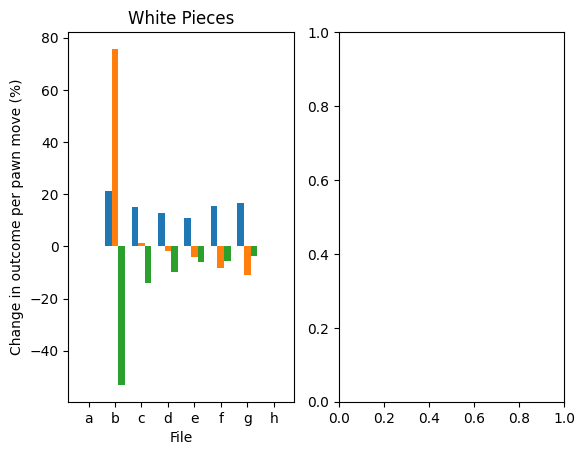

In [18]:
white_pawn_moves = df['white_pawn_moves'].tolist()
white_simple_results = df['white_simple_result'].tolist()

Xw_train, Xw_test, yw_train, yw_test = train_test_split(
     white_pawn_moves, white_simple_results, test_size=0.2, random_state=42)

w_model = LogisticRegression() # no differenc ebetwen solvers, see obsidian notes
w_model.fit(Xw_train, yw_train)

w_pred = w_model.predict(Xw_test)
w_pred_proba = w_model.predict_proba(Xw_test)

coeffs = w_model.coef_
coeffs = np.array(list(map(lambda x: list(map(lambda y: (np.e**y-1)*100, x)), coeffs)))
game_results = df['white_simple_result'].unique()

# Compute the evaluation metrics
accuracy = accuracy_score(yw_test, w_pred)
precision = precision_score(yw_test, w_pred, average='weighted')
recall = recall_score(yw_test, w_pred, average='weighted')
auc_roc = roc_auc_score(yw_test, w_pred_proba, multi_class='ovr')

# Create a dataframe with the evaluation metrics

df_metrics = pd.DataFrame([accuracy,precision, recall, auc_roc], index=['Accuracy', 'Precision', 'Recall', 'AUC-ROC'], columns=['White Score'])

# create x-axis ticks for each column value
x_ticks = np.arange(coeffs.shape[1])

# set the width of each bar
bar_width = 0.25

fig, (ax1, ax2) = plt.subplots(ncols=2)
# plot the bars
for i in range(coeffs.shape[0]):
    ax1.bar(x_ticks + i * bar_width, coeffs[i, :], width=bar_width, label=game_results[i])

# set the x-axis tick labels
ax1.set_xticks(x_ticks + bar_width, ['a','b','c','d','e','f','g','h'])
ax1.set_ylabel('Change in outcome per pawn move (%)')
ax1.set_xlabel('File')
ax1.set_title('White Pieces')

# set the legend

df_metrics.head()

#### black pieces

In [19]:
black_pawn_moves = df['black_pawn_moves'].tolist()
black_simple_results = df['black_simple_result'].tolist()

Xb_train, Xb_test, yb_train, yb_test = train_test_split(
     black_pawn_moves, black_simple_results, test_size=0.2, random_state=42)

b_model = LogisticRegression(multi_class='auto')
b_model.fit(Xb_train, yb_train)

b_pred = b_model.predict(Xb_test)
b_pred_proba = b_model.predict_proba(Xb_test)
print(b_pred_proba)

coeffs = b_model.coef_
coeffs = np.array(list(map(lambda x: list(map(lambda y: (np.e**y-1)*100, x)), coeffs)))

game_results = df['white_simple_result'].unique()

# Compute the evaluation metrics
accuracy = accuracy_score(yb_test, b_pred)
precision = precision_score(yb_test, b_pred, average='weighted')
recall = recall_score(yb_test, b_pred, average='weighted')
auc_roc = roc_auc_score(yb_test, b_pred_proba, multi_class='ovr')

df_metrics['Black Score'] = [accuracy,precision, recall, auc_roc]

# create x-axis ticks for each column value
x_ticks = np.arange(coeffs.shape[1])

# set the width of each bar
bar_width = 0.25

# plot the bars
for i in range(coeffs.shape[0]):
    ax2.bar(x_ticks + i * bar_width, coeffs[i, :], width=bar_width)

# set the x-axis tick labels
ax2.set_xticks(x_ticks + bar_width, ['a','b','c','d','e','f','g','h'])

ax2.set_xlabel('File')
ax2.set_title('Black Pieces')

# set the legend
df_metrics.head()
fig.legend()
fig.savefig('fig3.pdf')
fig.show()

[[0.01160063 0.54171187 0.4466875 ]
 [0.14490442 0.38077721 0.47431838]
 [0.02603815 0.45146005 0.5225018 ]
 ...
 [0.0152879  0.5157834  0.4689287 ]
 [0.05685615 0.46354761 0.47959624]
 [0.01837442 0.45530942 0.52631617]]


/tmp/ipykernel_169779/2864040324.py:47: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


### Equation for percentage increase in liklihood of outcome given one unit iuncreaase in relevent predictor variable
$p$ = percentage increase in outcome likliehood for one unit increase of predictor 

$c$ = coefficient value
$$p = (e^{c}-1)\cdot 100$$

# Random Forest Classifier

## 10 game results

#### *white pieces*

0.4940471434278865


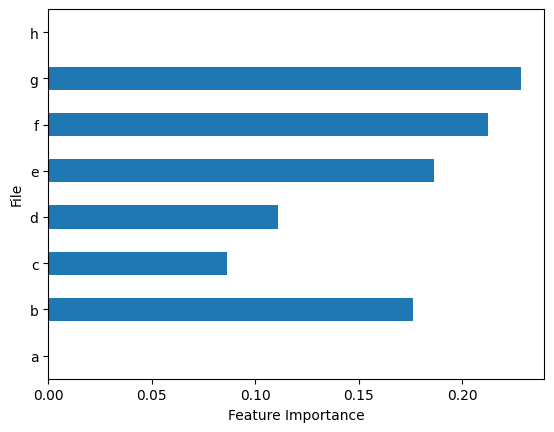

In [ ]:
white_pawn_moves = df['white_pawn_moves'].tolist()
white_results = df['white_result'].tolist()

Xw_train, Xw_test, yw_train, yw_test = train_test_split(
     white_pawn_moves, white_results, test_size=0.2, random_state=42)

w_model = RandomForestClassifier()
w_model.fit(Xw_train, yw_train)

w_pred = w_model.predict(Xw_test)
yw_pred_proba = w_model.predict_proba(Xw_test)[:, 1]

print(accuracy_score(yw_test, w_pred))
# print('ROC AUC: ', roc_auc_score(yw_test, yw_pred_proba))

# plot feature importances
importances = pd.Series(w_model.feature_importances_, index=['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h'])
importances.plot(kind='barh')
plt.xlabel('Feature Importance')
plt.ylabel('File')
plt.show()

#### *black pieces*

accuracy:  0.47423092289252894


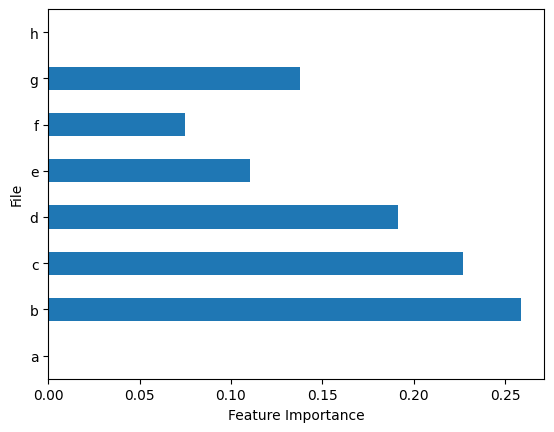

In [ ]:
black_pawn_moves = df['black_pawn_moves'].tolist()
black_results = df['black_result'].tolist()

Xb_train, Xb_test, yb_train, yb_test = train_test_split(
     black_pawn_moves, black_results, test_size=0.2, random_state=42)

b_model = RandomForestClassifier()

b_model.fit(Xb_train, yb_train)

b_pred = b_model.predict(Xb_test)
yb_pred_proba = b_model.predict_proba(Xb_test)[:, 1]

print('accuracy: ', accuracy_score(yb_test, b_pred))
# print('ROC AUC: ', roc_auc_score(yb_test, yb_pred_proba))

# plot feature importances
importances = pd.Series(b_model.feature_importances_, index=['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h'])
importances.plot(kind='barh')
plt.xlabel('Feature Importance')
plt.ylabel('File')
plt.show()

## win/loss/draw game results

#### *white pieces*

0.5346384338793447


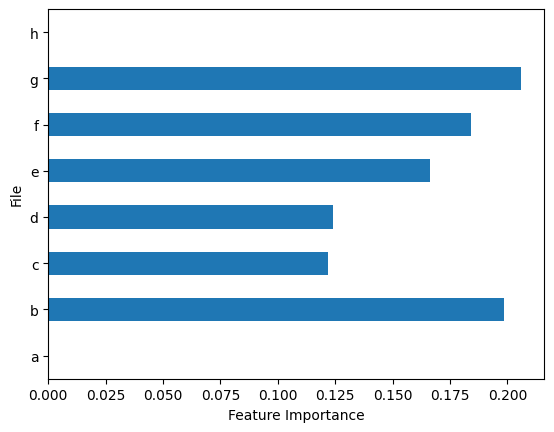

In [ ]:
white_pawn_moves = df['white_pawn_moves'].tolist()
white_results = df['white_simple_result'].tolist()

Xw_train, Xw_test, yw_train, yw_test = train_test_split(
     white_pawn_moves, white_results, test_size=0.2, random_state=42)

w_model = RandomForestClassifier()
w_model.fit(Xw_train, yw_train)

w_pred = w_model.predict(Xw_test)
yw_pred_proba = w_model.predict_proba(Xw_test)[:, 1]

print(accuracy_score(yw_test, w_pred))
# print('ROC AUC: ', roc_auc_score(yw_test, yw_pred_proba))

# plot feature importances
importances = pd.Series(w_model.feature_importances_, index=['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h'])
importances.plot(kind='barh')
plt.xlabel('Feature Importance')
plt.ylabel('File')
plt.show()

#### black pieces

accuracy:  0.5313623651618058


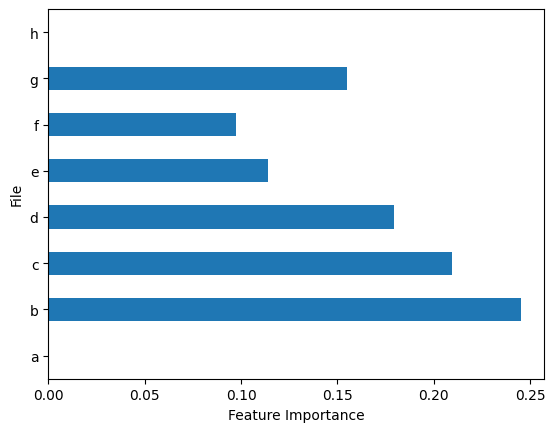

In [ ]:
black_pawn_moves = df['black_pawn_moves'].tolist()
black_results = df['black_simple_result'].tolist()

Xb_train, Xb_test, yb_train, yb_test = train_test_split(
     black_pawn_moves, black_results, test_size=0.2, random_state=42)

b_model = RandomForestClassifier()

b_model.fit(Xb_train, yb_train)

b_pred = b_model.predict(Xb_test)
yb_pred_proba = b_model.predict_proba(Xb_test)[:, 1]

print('accuracy: ', accuracy_score(yb_test, b_pred))
# print('ROC AUC: ', roc_auc_score(yb_test, yb_pred_proba))

# plot feature importances
importances = pd.Series(b_model.feature_importances_, index=['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h'])
importances.plot(kind='barh')
plt.xlabel('Feature Importance')
plt.ylabel('File')
plt.show()

## Binary game results

#### white pieces

0.550539352776668


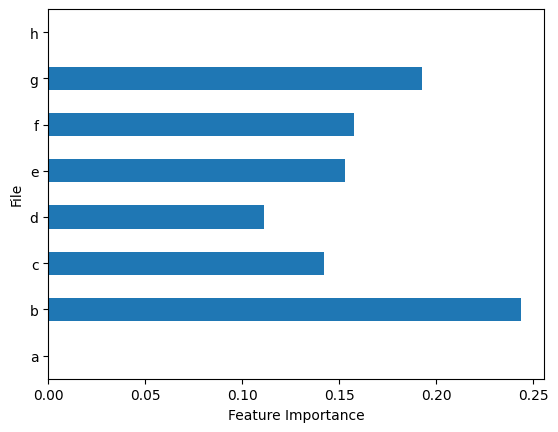

In [ ]:
white_pawn_moves = df['white_pawn_moves'].tolist()
white_results = df['white_win'].tolist()

Xw_train, Xw_test, yw_train, yw_test = train_test_split(
     white_pawn_moves, white_results, test_size=0.2, random_state=42)

w_model = RandomForestClassifier()
w_model.fit(Xw_train, yw_train)

w_pred = w_model.predict(Xw_test)
yw_pred_proba = w_model.predict_proba(Xw_test)[:, 1]

print(accuracy_score(yw_test, w_pred))
# print('ROC AUC: ', roc_auc_score(yw_test, yw_pred_proba))

# plot feature importances
importances = pd.Series(w_model.feature_importances_, index=['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h'])
importances.plot(kind='barh')
plt.xlabel('Feature Importance')
plt.ylabel('File')
plt.show()

#### black pieces

accuracy:  0.5476628046344387


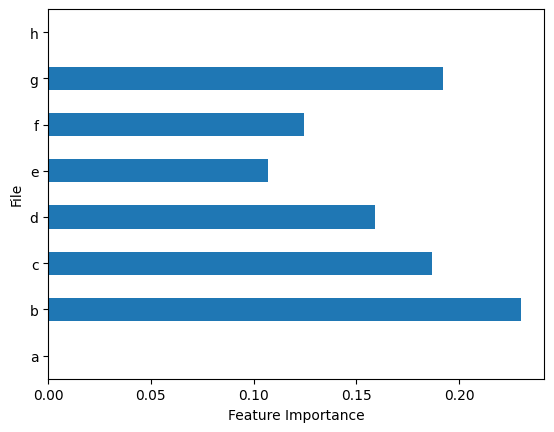

In [ ]:
black_pawn_moves = df['black_pawn_moves'].tolist()
black_results = df['black_win'].tolist()

Xb_train, Xb_test, yb_train, yb_test = train_test_split(
     black_pawn_moves, black_results, test_size=0.2, random_state=42)

b_model = RandomForestClassifier()

b_model.fit(Xb_train, yb_train)

b_pred = b_model.predict(Xb_test)
yb_pred_proba = b_model.predict_proba(Xb_test)[:, 1]

print('accuracy: ', accuracy_score(yb_test, b_pred))
# print('ROC AUC: ', roc_auc_score(yb_test, yb_pred_proba))

# plot feature importances
importances = pd.Series(b_model.feature_importances_, index=['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h'])
importances.plot(kind='barh')
plt.xlabel('Feature Importance')
plt.ylabel('File')
plt.show()

# K Nearest Neighboours

## Binary result classification

#### *white pieces*

In [ ]:
white_pawn_moves = df['white_pawn_moves'].tolist()
white_wins = df['white_win'].tolist()

Xw_train, Xw_test, yw_train, yw_test = train_test_split(
    white_pawn_moves, white_wins, test_size=0.2, random_state=42)

knn_model = KNeighborsClassifier(n_neighbors=400)
knn_model.fit(Xw_train, yw_train)

w_pred = knn_model.predict(Xw_test)

# Perform 10-fold cross-validation and calculate MSE for each fold
mse_scores = cross_val_score(knn_model, Xw_train, yw_train, cv=10, scoring='neg_mean_squared_error')
mse_scores = -mse_scores

# Calculate accuracy, bias and variance
accuracy = np.mean(1 - mse_scores)
bias = (yw_test - knn_model.predict(Xw_test)) ** 2
bias = np.mean(bias)
variance = np.var(knn_model.predict(Xw_train), ddof=1)
train_error_rate = 1 - knn_model.score(Xw_train, yw_train)
test_error_rate = 1 - knn_model.score(Xw_test, yw_test)

df_metrics = pd.DataFrame([accuracy,bias, variance, train_error_rate, test_error_rate], index=['Accuracy', 'Bias', 'Variance', 'Train Error Rate', 'Test Error Rate'], columns=['White Score'])
df_metrics.head()

,White Score
Accuracy,0.558792
Bias,0.441870
Variance,0.212602
Train Error Rate,0.433277
Test Error Rate,0.441870


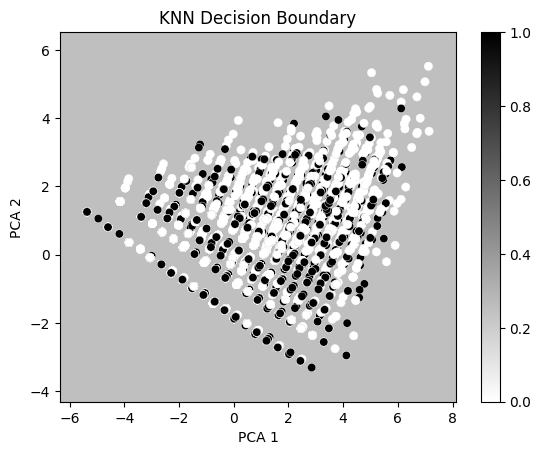

In [ ]:
# Use PCA to project the data into 2 dimensions
pca = PCA(n_components=2)
X_pca = pca.fit_transform(Xw_test)

# Create a meshgrid of points to evaluate the decision boundary
xx, yy = np.meshgrid(np.linspace(X_pca[:, 0].min()-1, X_pca[:, 0].max()+1, 100),
                     np.linspace(X_pca[:, 1].min()-1, X_pca[:, 1].max()+1, 100))

# Evaluate the KNN model at each point in the meshgrid
Z = knn_model.predict(pca.inverse_transform(np.c_[xx.ravel(), yy.ravel()]))

# Plot the decision boundary
Z = Z.reshape(xx.shape)
plt.contourf(xx, yy, Z, alpha=1, cmap='binary')
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=yw_test, alpha=1, cmap='binary', edgecolor='w', linewidths=0.3)
plt.colorbar()
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.title('KNN Decision Boundary')
plt.show()

#### Black Pieces

In [ ]:
black_pawn_moves = df['black_pawn_moves'].tolist()
black_wins = df['black_win'].tolist()

Xb_train, Xb_test, yb_train, yb_test = train_test_split(
    black_pawn_moves, black_wins, test_size=0.2, random_state=42)

knn_model = KNeighborsClassifier(n_neighbors=400)
knn_model.fit(Xb_train, yb_train)

b_pred = knn_model.predict(Xb_test)

# Perform 10-fold cross-validation and calculate MSE for each fold
mse_scores = cross_val_score(knn_model, Xb_train, yb_train, cv=10, scoring='neg_mean_squared_error')
mse_scores = -mse_scores

# Calculate accuracy, bias and variance
accuracy = np.mean(1 - mse_scores)
bias = (yb_test - knn_model.predict(Xb_test)) ** 2
bias = np.mean(bias)
variance = np.var(knn_model.predict(Xb_train), ddof=1)
train_error_rate = 1 - knn_model.score(Xb_train, yb_train)
test_error_rate = 1 - knn_model.score(Xb_test, yb_test)

df_metrics['Black Scores'] = [accuracy,bias, variance, train_error_rate, test_error_rate]
df_metrics.head()
print(df_metrics.to_latex())

\begin{tabular}{lrr}
\toprule
{} &  White Score &  Black Scores \\
\midrule
Accuracy         &     0.558792 &      0.566343 \\
Bias             &     0.441870 &      0.441390 \\
Variance         &     0.212602 &      0.238316 \\
Train Error Rate &     0.433277 &      0.427884 \\
Test Error Rate  &     0.441870 &      0.441390 \\
\bottomrule
\end{tabular}



/tmp/ipykernel_140166/4231742891.py:26: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(df_metrics.to_latex())


#### info on knn metrics

First, we split the dataset into training and testing sets. Then, we use k-fold cross-validation on the training set to obtain a more accurate estimate of the model's performance.

During k-fold cross-validation, the training set is divided into k subsets or "folds". For each fold, the model is trained on the remaining k-1 folds and evaluated on the held-out fold. This process is repeated k times, with each fold serving as the test set once.

The accuracy of the model is the average of the accuracy scores obtained on each fold during cross-validation. This metric measures the percentage of correct predictions made by the model.

The bias of the model is the difference between the expected prediction and the true value. High bias means that the model is underfitting the data, i.e. it is not complex enough to capture the underlying patterns in the data. This can lead to poor performance on both the training and test sets.

The variance of the model is the amount by which the predictions vary for different subsets of the training data. High variance means that the model is overfitting the data, i.e. it is too complex and is fitting the noise in the data instead of the underlying patterns. This can lead to good performance on the training set but poor performance on the test set.


## Ternary Result Classification

#### White Pieces

/home/anton/.local/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


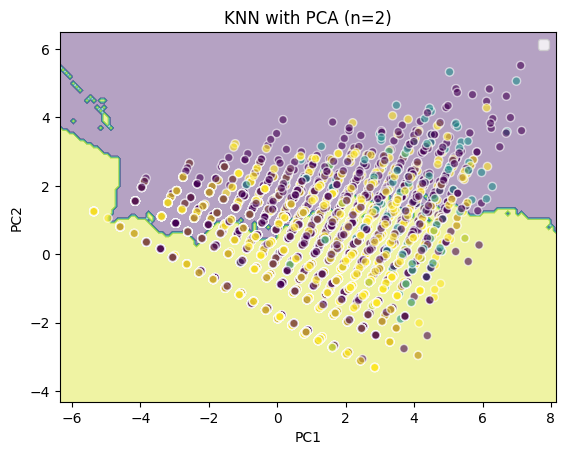

,Metric,Value
0,Accuracy,0.544626
1,Precision,0.376725
2,Recall,0.372977
3,AUC ROC,0.638893


In [ ]:
X = df['white_pawn_moves']
y = df['white_simple_result_ft']

# Convert the feature values to a numpy array and reshape
X = np.array(X.tolist()).reshape(-1, 8)

# Create a KNN model with k=5
knn = KNeighborsClassifier(n_neighbors=1600)

Xw_train, Xw_test, yw_train, yw_test = train_test_split(
    X, y, test_size=0.2, random_state=42)

# Fit the model to the training data
knn.fit(Xw_train, yw_train)

# Make predictions on the training and test data
train_preds = knn.predict(Xw_train)
test_preds = knn.predict(Xw_test)

# Calculate the evaluation metrics
accuracy = accuracy_score(yw_test, test_preds)
precision = precision_score(yw_test, test_preds, average='macro')
recall = recall_score(yw_test, test_preds, average='macro')
roc_auc = roc_auc_score(yw_test, knn.predict_proba(Xw_test), multi_class='ovr')

# Create a pandas dataframe to store the metrics
metrics_df = pd.DataFrame({
    'Metric': ['Accuracy', 'Precision', 'Recall', 'AUC ROC'],
    'Value': [accuracy, precision, recall, roc_auc]
})

# Apply PCA to the test data with n_components = 2
pca = PCA(n_components=2)
X_pca = pca.fit_transform(Xw_test)

# Define the meshgrid boundaries
x_min, x_max = X_pca[:, 0].min() - 1, X_pca[:, 0].max() + 1
y_min, y_max = X_pca[:, 1].min() - 1, X_pca[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1),
                     np.arange(y_min, y_max, 0.1))

# Create a scatter plot of the PCA-transformed test data with colored markers based on the true class

# Set the limits of the plot
plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())

# Use the KNN model to predict the class of the meshgrid points
Z = knn.predict(pca.inverse_transform(np.c_[xx.ravel(), yy.ravel()]))
Z = Z.reshape(xx.shape)

# Create a contour plot of the decision boundary
plt.contourf(xx, yy, Z, alpha=0.4, cmap='viridis')
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=yw_test, cmap='viridis', edgecolors='w', alpha=0.6)

# Add labels to the plot
plt.title("KNN with PCA (n=2)")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.legend()
plt.show()
metrics_df.head()

 # Misc .

#### pawn moves by elo

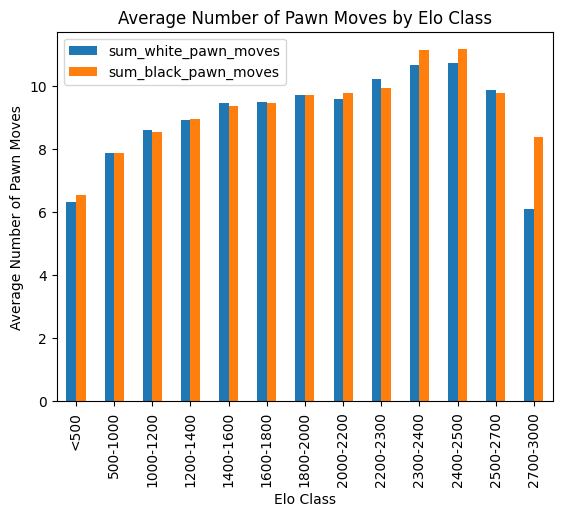

In [ ]:
# Calculate average number of pawn moves for each Elo class
pawn_moves_by_elo = df.groupby(
    'Elo_class')[['sum_white_pawn_moves', 'sum_black_pawn_moves']].mean()


# Plot bar graph
pawn_moves_by_elo.plot(kind='bar')
plt.xlabel('Elo Class')
plt.ylabel('Average Number of Pawn Moves')
plt.title('Average Number of Pawn Moves by Elo Class')
plt.savefig('fig1.pdf')


In [ ]:
white_pawn_moves = df['white_pawn_moves'].tolist()
white_wins = df['white_win'].tolist()

Xw_train, Xw_test, yw_train, yw_test = train_test_split(
    white_pawn_moves, white_wins, test_size=0.2, random_state=42)

accuracies = []
biass = []
variances = []


for i in range(1,51):
    knn_model = KNeighborsClassifier(n_neighbors=i)
    knn_model.fit(Xw_train, yw_train)

    w_pred = knn_model.predict(Xw_test)

    # Perform 10-fold cross-validation and calculate MSE for each fold
    mse_scores = cross_val_score(knn_model, Xw_train, yw_train, cv=10, scoring='neg_mean_squared_error')
    mse_scores = -mse_scores

    # Calculate accuracy, bias and variance
    accuracy = np.mean(1 - mse_scores)
    accuracies.append(accuracy)
    
    bias = (yw_test - knn_model.predict(Xw_test)) ** 2
    bias = np.mean(bias)
    biass.append(bias)

    variance = np.var(knn_model.predict(Xw_train), ddof=1)
    variances.append(variance)

fig, ax = plt.subplots()

ax.plot(range(1,51), accuracies, label='Accuracy')
ax.plot(range(1,51), biass, label='Bias')
ax.plot(range(1,51), variances, label='Variance')
ax.set_xlabel('k')
ax.set_ylabel('metric')
ax.legend(bbox_to_anchor=(1.05,1))

KeyboardInterrupt: 

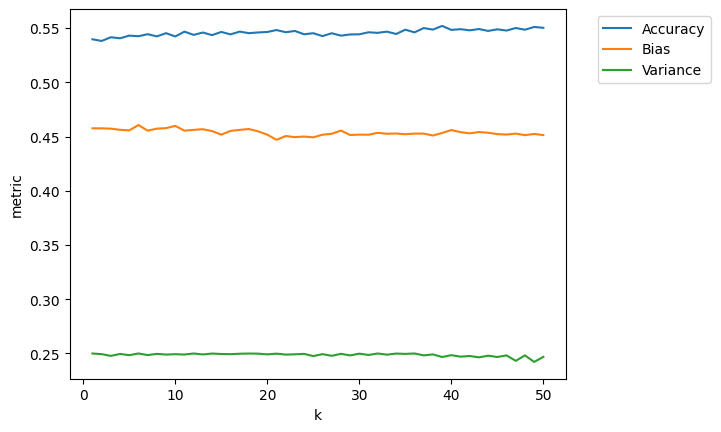

In [ ]:
white_pawn_moves = df['white_pawn_moves'].tolist()
white_wins = df['white_win'].tolist()

Xw_train, Xw_test, yw_train, yw_test = train_test_split(
    white_pawn_moves, white_wins, test_size=0.2, random_state=42)

accuracies = []
biass = []
variances = []

for i in range(51,101):
    knn_model = KNeighborsClassifier(n_neighbors=i)
    knn_model.fit(Xw_train, yw_train)

    w_pred = knn_model.predict(Xw_test)

    # Perform 10-fold cross-validation and calculate MSE for each fold
    mse_scores = cross_val_score(knn_model, Xw_train, yw_train, cv=10, scoring='neg_mean_squared_error')
    mse_scores = -mse_scores

    # Calculate accuracy, bias and variance
    accuracy = np.mean(1 - mse_scores)
    accuracies.append(accuracy)
    
    bias = (yw_test - knn_model.predict(Xw_test)) ** 2
    bias = np.mean(bias)
    biass.append(bias)

    variance = np.var(knn_model.predict(Xw_train), ddof=1)
    variances.append(variance)

fig, ax = plt.subplots()

ax.plot(range(51,101), accuracies, label='Accuracy')
ax.plot(range(51,101), biass, label='Bias')
ax.plot(range(51,101), variances, label='Variance')
ax.set_xlabel('k')
ax.set_ylabel('metric')
ax.legend(bbox_to_anchor=(1.05,1))

#### finding k for white (win/loss/draw)

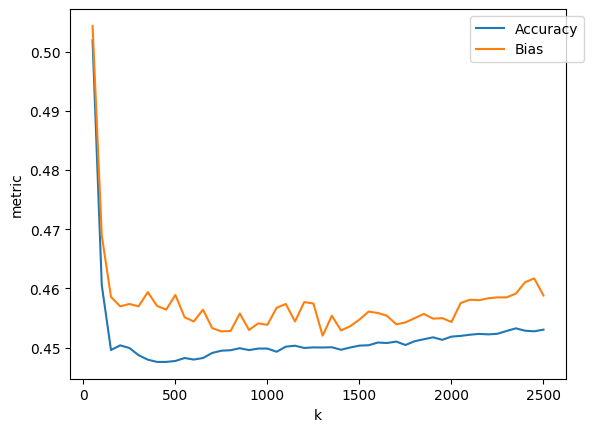

In [21]:
white_pawn_moves = df['white_pawn_moves'].tolist()
white_results = df['white_simple_result'].tolist()

Xw_train, Xw_test, yw_train, yw_test = train_test_split(
    white_pawn_moves, white_results , test_size=0.2, random_state=42)

accuracies = []
biass = []
variances = []
train_error_rate = []
test_error_rate = []

i = 1
iss = []
while i < 2500:
    knn_model = KNeighborsClassifier(n_neighbors=i)
    knn_model.fit(Xw_train, yw_train)

    w_pred = knn_model.predict(Xw_test)

    # Perform 10-fold cross-validation and calculate MSE for each fold
    # mse_scores = cross_val_score(knn_model, Xw_train, yw_train, cv=10, scoring='neg_mean_squared_error')
    # mse_scores = -mse_scores

    # Calculate accuracy, bias and variance
    # accuracy = np.mean(1 - mse_scores)
    # bias = (yw_test - knn_model.predict(Xw_test)) ** 2
    # bias = np.mean(bias)
    # variance = np.var(knn_model.predict(Xw_train), ddof=1)
    train_error_rate.append(1 - knn_model.score(Xw_train, yw_train))
    test_error_rate.append(1 - knn_model.score(Xw_test, yw_test))
    i+=50
    iss.append(i)

fig, ax = plt.subplots()

ax.plot(iss, train_error_rate, label='Accuracy')
ax.plot(iss, test_error_rate, label='Bias')
ax.set_xlabel('k')
ax.set_ylabel('metric')
ax.legend(bbox_to_anchor=(1.05,1))

In [ ]:
white_pawn_moves = df['white_pawn_moves'].tolist()
white_results = df['white_result'].tolist()

Xw_train, Xw_test, yw_train, yw_test = train_test_split(
    white_pawn_moves, white_results , test_size=0.2, random_state=42)

accuracies = []
biass = []
variances = []

for i in range(1,101):
    knn_model = KNeighborsClassifier(n_neighbors=i)
    knn_model.fit(Xw_train, yw_train)

    w_pred = knn_model.predict(Xw_test)

    # Perform 10-fold cross-validation and calculate MSE for each fold
    mse_scores = cross_val_score(knn_model, Xw_train, yw_train, cv=10, scoring='neg_mean_squared_error')
    mse_scores = -mse_scores

    # Calculate accuracy, bias and variance
    accuracy = np.mean(1 - mse_scores)
    accuracies.append(accuracy)
    
    bias = (yw_test - knn_model.predict(Xw_test)) ** 2
    bias = np.mean(bias)
    biass.append(bias)

    variance = np.var(knn_model.predict(Xw_train), ddof=1)
    variances.append(variance)

fig, ax = plt.subplots()

ax.plot(range(1,101), accuracies, label='Accuracy')
ax.plot(range(1,101), biass, label='Bias')
ax.plot(range(1,101), variances, label='Variance')
ax.set_xlabel('k')
ax.set_ylabel('metric')
ax.legend(bbox_to_anchor=(1.05,1))

/home/anton/.local/lib/python3.11/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=10.
  warnings.warn(
/home/anton/.local/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:794: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/anton/.local/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 115, in __call__
    score = scorer._score(cached_call, estimator, *args, **kwargs)
            ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/anton/.local/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 282, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
                        ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/anton/.local/lib/python3.11/site-packages/sklear

UFuncTypeError: ufunc 'subtract' did not contain a loop with signature matching types (dtype('<U18'), dtype('<U18')) -> None